# Capstone 2. Data cleaning & storytelling

July, 2018
***


**Objective:** As I mentioned in the proposal, the major goal of this capstone project is to help job seekers, especially those new graduates with not previous job experience, find their dream job based on their answers to our questionnaire. Because extensive web scrap is perhibited in those major job posting website such as Linkedin and indeed, I chose an job description data set from Kaggle.com. Data source: [kaggle dataset](https://www.kaggle.com/PromptCloudHQ/us-jobs-on-monstercom)

Questionnaire will cover those aspects:
- Industry 
- Location
- Culture

Each aspect need the user a number indicating the level of the importance.

And finally, we will do a matching between job descriptions and the answer of the questionnaire.
***
*For example: *

I may answer the questionnaire in this way:

- Industry = art; artificial intelligence. Weight = 40%
- Location = big cities; eastern coast. Weight = 20%
- Culture = innovation; big company. Weight = 40%

And I hope to get job recommendations from this project.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import nltk
from time import sleep
import math
import seaborn as sns

plt.style.use('fivethirtyeight')

# Section 1: The dataset

In [2]:
# import the dataset and see how it looks like
df = pd.read_csv('monster_com-job_sample 2.csv')

# some basic inforamtion
print('There are {:d} job decriptions in the dataset.'.format(df.shape[0]))
print('The jobs are located in those country: ', df.country_code.unique().item())
print('{:d} out of 22000 job descriptions are tagged with a salary'.format(22000-sum(df.salary.isnull())))

There are 22000 job decriptions in the dataset.
The jobs are located in those country:  US
3446 out of 22000 job descriptions are tagged with a salary


In [3]:
# drop columns that are not helpful for the following analysis
df = df.drop(df.columns[[0,1,2,3,4,7,10,11,12,13]],axis=1)
df.head()

,job_description,job_title,location,organization
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing
2,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,DePuy Synthes Companies is a member of Johnson...,Personal and Household Services
3,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,"Dixon, CA",Altec Industries
4,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,"Camphill, PA",Retail


In this dataset, we kept those columns which would be useful in the following sections. 
 - The **job_description** and **job_title** will be used to match industry. 
 - **organization** will be used for finding the name of that company and the culture of it. 
 - **location**, will be used to calculate distance, as well as finding out if the job located at big or small city, with increasing or declining population and so on.

# Section 2: Location 

### Extract the location information: zip code, state, city
Notice that this dataset is not cleaned. The locations have different format so that we need to extract that information use some technology such as regular expression.


In [4]:
# extract zip code information from the location column
# extract state information from the location column
p = re.compile(r'(?<![A-Z])[A-Z]{2}(?![A-Z])')
for i, row in df.iterrows():
    # add the column zip code
    ls = []
    for char in row.location:
        if char.isdigit():
            ls.append(char)
    if len(ls) == 5:
        df.set_value(i,'zip_code', ''.join(ls))
    
    # add the column state
    str_location = row.location
   
    if len(str_location) < 100 and len(str_location) > 1:
        state = p.search(str_location)
        if state is not None:
            df.set_value(i, 'state', state.group())
            ls = str_location.split(',')
            df.set_value(i, 'city', ls[0])
df.head()

,job_description,job_title,location,organization,zip_code,state,city
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN,53702,WI,Madison
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing,53708,WI,Madison
2,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,DePuy Synthes Companies is a member of Johnson...,Personal and Household Services,NaN,NaN,NaN
3,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,"Dixon, CA",Altec Industries,NaN,CA,Dixon
4,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,"Camphill, PA",Retail,NaN,PA,Camphill


### Dataset exploration 1: look at locations that have the biggest number of jobs

There are 19194 jobs that shows which City they located at.


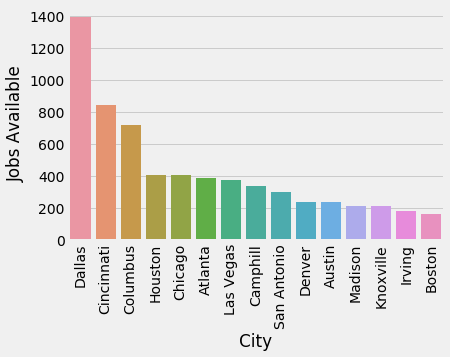

In [5]:
df_dropna = df[~df.state.isnull()]
print('There are %d jobs that shows which City they located at.' % len(df_dropna))

data = df_dropna.groupby('city').count().job_description.sort_values(ascending = False)[:15]
df_data = data.to_frame()
df_data['city'] = df_data.index
df_data.columns = ['Jobs Available', 'City']

g = sns.barplot(x='City', y='Jobs Available', data=df_data)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

There are 19194 jobs that shows which State they located at.


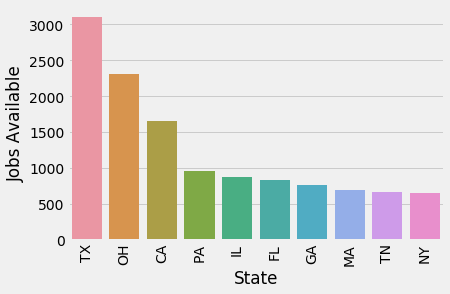

In [6]:
data = df_dropna.groupby('state').count().job_description.sort_values(ascending = False)[:10]
print('There are %d jobs that shows which State they located at.' % len(df_dropna))
df_data = data.to_frame()
df_data['State'] = df_data.index
df_data.columns = ['Jobs Available', 'State']

g = sns.barplot(x='State', y='Jobs Available', data=df_data)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Dataset exploration 2: save the DataFrame as excel and mapping the data in the USA map.

In [7]:
df_dropna_zip = df[~df.zip_code.isnull()]
print('There are %d jobs that shows which zip_code they located at.' % len(df_dropna_zip))

There are 12059 jobs that shows which zip_code they located at.


![map](map.png)

https://plot.ly/python/bubble-maps/

In [8]:
df_dropna_zip.head()

,job_description,job_title,location,organization,zip_code,state,city
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN,53702,WI,Madison
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing,53708,WI,Madison
7,RESPONSIBILITIES:Kforce has a client seeking a...,Mailroom Clerk Job in Austin,"Austin, TX 73301",NaN,73301,TX,Austin
8,"Part-Time, 4:30 pm - 9:30 pm, Mon - Fri Brookd...",Housekeeper Job in Austin,"Austin, TX 78746",Hotels and Lodging Personal and Household Serv...,78746,TX,Austin
10,Aflac Insurance Sales Agent While a career in ...,Aflac Insurance Sales Agent Job in Berryville,"Berryville, VA 22611",Insurance,22611,VA,Berryville


In [9]:
# this panda series contains the number of jobs in each zip code
data = df_dropna_zip.groupby('zip_code').count().job_description.sort_values(ascending = False)

zip_code
75201    311
43215    139
45202     91
60603     89
89119     64
45201     56
75202     52
45242     49
60601     49
80202     48
37917     44
45246     39
75062     38
89106     36
37421     36
43219     32
60602     32
43085     31
45241     31
75207     29
77001     29
92121     29
71203     28
30328     27
71105     27
75019     27
92123     26
53703     26
54601     26
75204     26
        ... 
75213      1
75232      1
75041      1
75233      1
37122      1
37078      1
75252      1
75261      1
75355      1
75376      1
75149      1
75137      1
75134      1
75115      1
75042      1
37416      1
37415      1
37408      1
37405      1
37404      1
75067      1
75070      1
37388      1
37356      1
75075      1
75080      1
75087      1
75098      1
37312      1
99518      1
Name: job_description, Length: 4411, dtype: int64

### Determine the location index.
Location index is determined by the distance from where the job is and where the job seeker currently located. The index is also determined by the quality of the location. People may care different things about the location, such as the population, safety, near big city, near national park, city or country, art, education and so on. We can put all those factors in the questionnaire. This location index can be very complex and it would be impossible to complete in a short time. We'll simplify the calculation by picking 1 or 2 factors, like distance from home and population.


————note:
give a new map that shows the index of the locations. 

In [10]:
# calculate distance based on zip code
from pyzipcode import ZipCodeDatabase

zcdb = ZipCodeDatabase()
zipcode = zcdb[84112]
lan_home = zipcode.latitude
lon_home = zipcode.longitude

df_zip = df[df['zip_code'].notnull()]
df_zip = df_zip[~(df_zip['zip_code']=='00000')]

for i, row in df_zip.iterrows():
    #calculate distance
    try:
        zipcode = zcdb[row.zip_code]
        lan = zipcode.latitude
        lon = zipcode.longitude
        distance = math.sqrt((lan-lan_home)**2+(lon-lon_home)**2)
        df.set_value(i, 'distance_home', distance)
    except:
        pass

In [11]:
df_zip.shape

(12054, 7)

In [28]:
df_zip.head()

,job_description,job_title,location,organization,zip_code,state,city
0,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,"Madison, WI 53702",NaN,53702,WI,Madison
1,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,"Madison, WI 53708",Printing and Publishing,53708,WI,Madison
7,RESPONSIBILITIES:Kforce has a client seeking a...,Mailroom Clerk Job in Austin,"Austin, TX 73301",NaN,73301,TX,Austin
8,"Part-Time, 4:30 pm - 9:30 pm, Mon - Fri Brookd...",Housekeeper Job in Austin,"Austin, TX 78746",Hotels and Lodging Personal and Household Serv...,78746,TX,Austin
10,Aflac Insurance Sales Agent While a career in ...,Aflac Insurance Sales Agent Job in Berryville,"Berryville, VA 22611",Insurance,22611,VA,Berryville


There are 12054 jobs in the dataset that has the distance information calcuated from zip code.

Population is an important aspect when investigating a location. First, the larger the population in that area means that it's more like a city area instead of an rural area. Second, we can also monitor the change of the population. If there is an increase of population, it may indicate that that area have a good amount job opportunity and overall healthy economy. I use this data source: [US Population By Zip Code
For both 2000 and 2010](https://www.kaggle.com/census/us-population-by-zip-code#population_by_zip_2000.csv)

In [13]:
# load the dataset
df_zip_2000 = pd.read_csv('us-population-by-zip-code/population_by_zip_2000.csv')
df_zip_2010 = pd.read_csv('us-population-by-zip-code/population_by_zip_2010.csv')

In [14]:
# sum up the population in a zipcode area
df_2010 = df_zip_2010.groupby('zipcode').sum()['population'].to_frame()
df_2000 = df_zip_2000.groupby('zipcode').sum()['population'].to_frame()
df_2000['zip'] = df_2000.index
df_2010['zip'] = df_2010.index

In [15]:
for i in df_2000:
    print(i)

population
zip


In [16]:
pd.merge(df_2000, df_2010, on='zip', how = 'right')

,population_x,zip,population_y
0,NaN,602,124560
1,NaN,603,164067
2,NaN,606,19845
3,NaN,610,87048
4,NaN,612,201030
5,NaN,616,33051
6,NaN,617,73791
7,NaN,622,23559
8,NaN,623,129183
9,NaN,624,78723


# Section 3: Culture

In this section, we're trying to judge the culture of a company by the size of the company as well as some key adjectives in the job descriptions, such as "flexible", "motivated", "innovative" and so on.


### Step 1: extract company information
We want to extract company information, which means we get the name of the company, and we can find out more about the company by google it. When we want to know about a company, we look at several things, like the size of the company, the history of the company, the review of the company as well as if I have networks in there. The same as the previous location section, it can be a big task to complete all the factors we can think of. But I will pick up a few for practice, such as the size of the company.

In this dataset, it's a little challenging to get the company name because the company name is not clearly marked in the dataset.

The company name is usually associated with key words like "seek", "join". But still, this not always the case. And from the first job description, the word "seeking" was misspelled as "seeing". 

In [17]:
# Let's look at an example: 
sample = df.job_description[2]

From the above example:

The company we may want extract is "The Wisconsin State Journal". "to lead its three-person business desk", even I have no idea what does that mean. This maybe confusion that "three people" sounds like a startup company, but actually not.

After extracting the company information, we would like to link with another dataset that includes the information of major companies. 

In [18]:
import nltk

sentence = sample
tokens = nltk.word_tokenize(sentence)

tagged = nltk.pos_tag(tokens)
tagged

[('Report', 'NN'),
 ('this', 'DT'),
 ('job', 'NN'),
 ('About', 'IN'),
 ('the', 'DT'),
 ('Job', 'NNP'),
 ('DePuy', 'NNP'),
 ('Synthes', 'NNP'),
 ('Companies', 'NNP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('member', 'NN'),
 ('of', 'IN'),
 ('Johnson', 'NNP'),
 ('&', 'CC'),
 ('Johnson', 'NNP'),
 ("'s", 'POS'),
 ('Family', 'NNP'),
 ('of', 'IN'),
 ('Companies', 'NNP'),
 (',', ','),
 ('and', 'CC'),
 ('is', 'VBZ'),
 ('recruiting', 'VBG'),
 ('for', 'IN'),
 ('a', 'DT'),
 ('Senior', 'JJ'),
 ('Training', 'NN'),
 ('Leader', 'NNP'),
 ('located', 'VBN'),
 ('in', 'IN'),
 ('Raynham', 'NNP'),
 (',', ','),
 ('MA.DePuy', 'NNP'),
 ('Synthes', 'NNP'),
 ('Companies', 'NNP'),
 ('of', 'IN'),
 ('Johnson', 'NNP'),
 ('&', 'CC'),
 ('Johnson', 'NNP'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('largest', 'JJS'),
 (',', ','),
 ('most', 'RBS'),
 ('innovative', 'JJ'),
 ('and', 'CC'),
 ('comprehensive', 'JJ'),
 ('orthopedic', 'NN'),
 ('and', 'CC'),
 ('neurological', 'JJ'),
 ('business', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('world'

### Step 2: extract the adjectives from the job description.

## I. extract keywords from a text:
3. parsing the text, find out nouns and adjectives.
1. remove stopwords
2. word stemming

4. rank the nouns and adjectives by the relavent of the job seeking

## II. vectorize the keywords of each job description


In [19]:
adj = [x[0] for x in tagged if x[1] == 'JJ']
noun = [x[0] for x in tagged if x[1] == 'NN' or x[1]=='NNS']

In [20]:
# remove stopword
fh = open('english.stop.txt','r')
ls_stopword = []
for item in fh:
    ls_stopword.append(item.rstrip('\n'))
                       
adj_removed = [x for x in adj if x not in ls_stopword]
noun_removed = [x for x in noun if x not in ls_stopword]

# remove symbols
ls_symbols = ['[',']','<','>','%',' ', '•', 'null', 'x', '$', '+']
                       
adj_removed = [x for x in adj if x not in ls_symbols]
noun_removed = [x for x in noun if x not in ls_symbols]

In [21]:
c_noun = Counter(noun_removed)

In [22]:
c_adj = Counter(adj_removed)

In [23]:
c_noun = Counter(noun_removed)
c_noun.most_common(10)

[('training', 15),
 ('programs', 7),
 ('company', 6),
 ('management', 6),
 ('Caption', 6),
 ('experience', 5),
 ('http', 5),
 ('needs', 4),
 ('personnel', 4),
 ('site', 3)]

In [24]:
# count all of the jobs
adj_all = []
noun_all = []

for i in tqdm(range(len(df))):
    sample = df.job_description[i]
    
    sentence = sample
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    
    adj = [x[0] for x in tagged if x[1] == 'JJ']
    noun = [x[0] for x in tagged if x[1] == 'NN' or x[1]=='NNS']
    
    # remove stopword
    fh = open('english.stop.txt','r')
    ls_stopword = []
    for item in fh:
        ls_stopword.append(item.rstrip('\n'))

    adj_removed = [x for x in adj if x not in ls_stopword]
    noun_removed = [x for x in noun if x not in ls_stopword]

    # remove symbols
    ls_symbols = ['[',']','<','>','%',' ', '•', 'null', 'x', '$', '+', '*', '·','s']

    adj_removed = [x for x in adj if x not in ls_symbols]
    noun_removed = [x for x in noun if x not in ls_symbols]
    
    for item_adj in adj_removed:
        adj_all.append(item_adj)
    for item_noun in noun_removed:
        noun_all.append(item_noun)
    sleep(0.01)

100%|██████████| 22000/22000 [8:38:02<00:00,  1.41s/it]   


In [25]:
c_noun_all = Counter(noun_all)
c_adj_all = Counter(adj_all)

In [26]:
c_noun_all.most_common(100)

[('experience', 33645),
 ('skills', 21803),
 ('customer', 21645),
 ('team', 19215),
 ('work', 18801),
 ('service', 18717),
 ('management', 17943),
 ('years', 17706),
 ('company', 16494),
 ('business', 16418),
 ('position', 16296),
 ('sales', 15608),
 ('customers', 13818),
 ('job', 13383),
 ('environment', 11456),
 ('ability', 10835),
 ('time', 10516),
 ('equipment', 10453),
 ('services', 10400),
 ('quality', 10393),
 ('knowledge', 10330),
 ('information', 10154),
 ('training', 10025),
 ('care', 9955),
 ('duties', 9870),
 ('development', 9650),
 ('requirements', 9411),
 ('communication', 9378),
 ('project', 9269),
 ('product', 9089),
 ('products', 9088),
 ('client', 8885),
 ('support', 8521),
 ('procedures', 8202),
 ('opportunity', 8051),
 ('process', 7959),
 ('and/or', 7874),
 ('benefits', 7854),
 ('employees', 7764),
 ('systems', 7577),
 ('data', 7512),
 ('needs', 7253),
 ('level', 6937),
 ('store', 6818),
 ('safety', 6644),
 ('maintenance', 6630),
 ('industry', 6591),
 ('people', 657

In [27]:
c_adj_all.most_common(100)

[('other', 20164),
 ('new', 9715),
 ('able', 9392),
 ('such', 7771),
 ('technical', 7526),
 ('responsible', 6959),
 ('professional', 6178),
 ('strong', 5911),
 ('high', 5409),
 ('financial', 5331),
 ('related', 5268),
 ('medical', 5242),
 ('general', 5013),
 ('appropriate', 4659),
 ('internal', 4648),
 ('local', 4500),
 ('necessary', 4279),
 ('daily', 4233),
 ('Equal', 4142),
 ('great', 4072),
 ('safe', 3988),
 ('multiple', 3942),
 ('current', 3620),
 ('excellent', 3536),
 ('various', 3502),
 ('national', 3466),
 ('physical', 3429),
 ('successful', 3419),
 ('competitive', 3266),
 ('basic', 3256),
 ('retail', 3210),
 ('limited', 3205),
 ('timely', 3199),
 ('available', 3174),
 ('applicable', 3122),
 ('essential', 3108),
 ('external', 3106),
 ('and/or', 3069),
 ('equivalent', 3061),
 ('qualified', 3055),
 ('personal', 2932),
 ('proper', 2902),
 ('assigned', 2835),
 ('verbal', 2775),
 ('direct', 2759),
 ('good', 2751),
 ('full', 2750),
 ('effective', 2699),
 ('organizational', 2656),
 ('p

# Section 4: Industry

In this section, we're trying to get the industry information of the company. Industry such as sports, media, software, communication, devices, music, non-profit and so on. This information may found from those nouns of the job description. For example, from the job description example of Section 3, we may find "Journal", "reporter", "editor", "journalist", "trends" and so on may be a good represent of the industry of the company.